In [2]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e

dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed'
    }

TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(ll[1])+int(1000)))

TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')
up = 1000
down = 1000

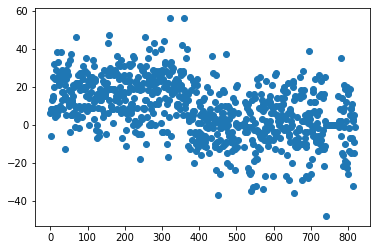

In [22]:
score_HK = []
tss_HK = []
for j, tss in enumerate(TSS_HK):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
    ss = []
    for i in range(1,up+down):
        if cov[i] < cov[i-1]:
            ss.append(1)
        elif cov[i] > cov[i-1]:
            ss.append(-1)
        else:
            ss.append(0)
    k = 1000
    sss = sum(ss[:k]) - sum(ss[k:])
    score_HK.append(sss)
    tss_HK.append(k)
plt.scatter([x for x in range(len(score_HK))], score_HK)
plt.show()



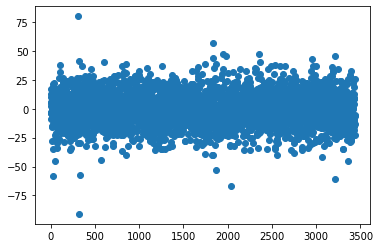

In [21]:
score_non = []
tss_non = []
for j, tss in enumerate(TSS_NonGene):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
    ss = []
    for i in range(1,up+down):
        if cov[i] < cov[i-1]:
            ss.append(1)
        elif cov[i] > cov[i-1]:
            ss.append(-1)
        else:
            ss.append(0)
    k = 1000
    sss = sum(ss[:k]) -sum(ss[k:])
    score_non.append(sss)
    tss_non.append(k)
plt.scatter([x for x in range(len(score_non))], score_non)
plt.show()

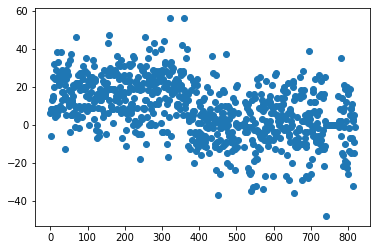

In [12]:
score_HK = []
for j, tss in enumerate(TSS_HK):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
    ss = 0
    for i in range(1,up+down):
        if i <= 1000:
            if cov[i] < cov[i-1]:
                ss += 1
            elif cov[i] > cov[i-1]:
                ss -= 1
        else:
            if cov[i] > cov[i-1]:
                ss += 1
            elif cov[i] < cov[i-1]:
                ss -= 1
    score_HK.append(ss)
plt.scatter([x for x in range(len(score_HK))], score_HK)
plt.show()